## *Autoencoders vs Variational Autoencoders*
### **Autoencoders**

When comparing them with GANs, Variational Autoencoders are particularly useful when you wish to adapt your data rather than purely generating new data, due to their structure.

If we do wish to create new content, we really want our latent space to satisfy two criteria (Rocca, 2019):

1.   It must be continuous. This means that two close points in the latent space should give two similar outputs when decoded.
2.   It must be complete. This means that a point sampled from the distribution should produce an output that makes sense. The thing with classic autoencoders is this: they’re likely neither.

The thing with classic autoencoders is this: they’re likely neither.

In machine learning terms, this means that the only goal of the classic autoencoder is to minimize reconstruction loss. Minimizing reconstruction loss needs no continuity or completeness. Nope, it only needs learning a way of generating encodings for inputs that maximize reconstruction to the desired output. Whether this happens with or without a continuous and complete state, is of no concern to the autoencoder.

### **Variational Autoencoders**

1.   Firstly, recall that classic autoencoders output one value per dimension when mapping input data to latent state. VAEs don’t do this: rather, they output a Gaussian probability distribution with some mean μ and standard deviation σ for every dimension. For example, when the latent state space has seven dimensions, you’d thus get seven probability distributions that together represent state, as a probability distribution across space.
2.   Secondly, contrary to classic autoencoders – which minimize reconstruction loss only – VAEs minimize a combination of reconstruction loss and a probability comparison loss called Kullback-Leibler divergence. This enforces the regularization we so deeply need.

These two differences allow them to be both continuous and, quite often, complete, making VAEs candidates for generative processes.




In [1]:
"""This code creates problem while implementing vae.fit() in tf2.x. Use tf1.x for running this code.\
I have created a new enviroment with name tf-gpu-1.x in anaconda to run this code.\ 
Run Jupyter notebook from Anaconda tf-gpu-1.x environment.\
In Google Colab you can use this line of code *%tensorflow_version 1.x* (without asterisk) to directly use tf1.x version."""

'This code creates problem while implementing vae.fit() in tf2.x. Use tf1.x for running this code.I have created a new enviroment with name tf-gpu-1.x in anaconda to run this code.\\ \nRun Jupyter notebook from Anaconda tf-gpu-1.x environment.In Google Colab you can use this line of code *%tensorflow_version 1.x* (without asterisk) to directly use tf1.x version.'

In [2]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [3]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [4]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('val_loss') < 1e-6) and (logs.get('loss') < 1e-6):
        print("\nReached perfect loss so cancelling training!")
        self.model.stop_training = True

epoch_schedule = myCallback()

In [5]:
"""
 - R^2 coefficient for variance
 - The higher the R-squared, the better the model fits your data.

"""
from keras import backend as K
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

Using TensorFlow backend.


In [6]:
# import dataset
def load_labels(m):
    dfUD = pd.DataFrame(np.zeros((m,1), dtype=int))
    dfD = pd.DataFrame(np.ones((m,1), dtype=int))
    return dfUD, dfD

def load_imagesUD(dfUD,pathUD):
    imagesUD = []
    for i in dfUD.index.values:
        baseUD = os.path.sep.join([pathUD, "Baseline-{}.png".format(i + 1)])
        image = cv2.imread(baseUD) # read the path using opencv
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2.COLOR_BGR2GRAY
        image = cv2.resize(image, (256, 256))
        #plt.imshow(image) # use matplotlib to plot the image
        #image = image[:,:,np.newaxis] #This is convert (600,600) --> (600,600,1)
        imagesUD.append(image) 
    return np.array(imagesUD)

def load_imagesD(dfD,pathD):
    imagesD = []
    for i in dfD.index.values:
        baseD = os.path.sep.join([pathD, "Damage-{}.png".format(i + 1)])
        image = cv2.imread(baseD) # read the path using opencv
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        #plt.imshow(image) # use matplotlib to plot the image
        #image = image[:,:,np.newaxis] #This is convert (600,600) --> (600,600,1)
        imagesD.append(image) 
    return np.array(imagesD)

In [7]:
# import the necessary packages
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import Dropout

In [8]:
class CVAE:
	@staticmethod
	def build(width, height, depth, filters=(16, 32, 64, 128, 256), latent_dim = 2):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape = inputShape, name='encoder_input')
		cx = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			cx = Conv2D(f, (3, 3), strides = 2, padding="same")(cx)
			cx = LeakyReLU(alpha=0.2)(cx)
			cx = BatchNormalization(axis=chanDim)(cx)
			#x = MaxPooling2D(pool_size=(2,2))(x)

    # flatten the network and then construct our latent vector
		x = Flatten()(cx)
		x = Dense(50, activation='relu')(x)
		x = Dropout(0.1)(x)
		x = BatchNormalization()(x)
		mu = Dense(latent_dim, name='latent_mu')(x)
		sigma = Dense(latent_dim, name='latent_sigma')(x)

    # Get Conv2D shape for Conv2DTranspose operation in decoder
		volumeSize = K.int_shape(cx)

    # Define sampling with reparameterization trick
		def sample_z(args):
			mu, sigma = args
			batch = K.shape(mu)[0]
			dim   = K.int_shape(mu)[1]
			eps   = K.random_normal(shape=(batch, dim))
			return mu + K.exp(sigma / 2) * eps

    # Use reparameterization trick to ensure correct gradient
		z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

    # build the encoder model
		encoder = Model(inputs, [mu, sigma, z], name='encoder')

    # Decoder model ==> It will accept the output of the encoder as its inputs
		latentInputs = Input(shape=(latent_dim,), name='decoder_input')
		x = BatchNormalization()(latentInputs)
		x = Dense(np.prod(volumeSize[1:]))(x)
		cx = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		# loop over our number of filters again, but this time in reverse order
		for f in filters[::-1]: # filters[::-1] = [256,128,64,32,16]
			# apply a CONV_TRANSPOSE => RELU => BN operation
			cx = Conv2DTranspose(f, (3, 3), strides = 2, padding="same")(cx)
			cx = LeakyReLU(alpha=0.2)(cx)
			cx = BatchNormalization(axis=chanDim)(cx)
			#x = UpSampling2D(size=(2,2))(x)

		# apply a single CONV_TRANSPOSE layer used to recover the original depth of the image
		cx = Conv2DTranspose(depth, (3, 3), padding="same")(cx)
		outputs = Activation("sigmoid")(cx)

		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")

		# our variational autoencoder is the encoder + decoder
		vae = Model(inputs, decoder(encoder(inputs)), name="vae")

		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, vae, mu, sigma)

In [9]:
# construct our vae
print("[INFO] building vae...")
(encoder, decoder, vae, mu, sigma) = CVAE.build(256, 256, 3)

[INFO] building vae...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [11]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 2)                 8         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             49152     
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       590080    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 256)       1024

In [12]:
# location of images
pathD = 'E:/OneDrive - Indian Institute of Science/PhD-MSR/OGWdataset/Wavelet_Dataset/Wavelet_dataset-1/Damage'
pathUD = 'E:/OneDrive - Indian Institute of Science/PhD-MSR/OGWdataset/Wavelet_Dataset/Wavelet_dataset-1/Baseline'

In [13]:
# test the import of the images
import matplotlib.pyplot as plt
import random
import cv2
images = []
for i in range(2):
    print(i)
    base = os.path.sep.join([pathUD, "Baseline-{}.png".format(i + 1)])
    print(base)
    image0 = cv2.imread(base) # read the path using opencv #,cv2.IMREAD_GRAYSCALE
    image0 = cv2.cvtColor(image0, cv2.COLOR_BGR2RGB)
    image0 = cv2.resize(image0, (256, 256))
    plt.imshow(image0) # use matplotlib to plot the image
    #image0 = image0[:,:,np.newaxis] #This is convert (600,600) --> (600,600,1)
    images.append(image0)

np.array(images).shape

0
E:/OneDrive - Indian Institute of Science/PhD-MSR/OGWdataset/Wavelet_Dataset/Wavelet_dataset-1/Baseline\Baseline-1.png
1
E:/OneDrive - Indian Institute of Science/PhD-MSR/OGWdataset/Wavelet_Dataset/Wavelet_dataset-1/Baseline\Baseline-2.png


(2, 256, 256, 3)

In [14]:
# Labels
[dfUD,dfD] = load_labels(18000)
df = np.concatenate([dfUD, dfD], axis=0)
print(df.shape)

# Import the D images
imagesUD = load_imagesUD(dfUD, pathUD)
imagesUD = imagesUD.astype('float32')
imagesUD = imagesUD / 255

# Import the D images
imagesD = load_imagesD(dfD, pathD)
imagesD = imagesD.astype('float32')
imagesD = imagesD / 255

print("Shape of Healthy images", imagesUD.shape)
print("Shape of UnHealthy images",imagesD.shape)

(36000, 1)
Shape of Healthy images (18000, 256, 256, 3)
Shape of UnHealthy images (18000, 256, 256, 3)


In [15]:
import random
n1 = np.random.randint(0, 18000, 5000)
imUD = imagesUD[n1]
imD = imagesD[n1]
print("New Undamaged dataset",imUD.shape)
print("New damaged dataset",imD.shape)

New Undamaged dataset (5000, 256, 256, 3)
New damaged dataset (5000, 256, 256, 3)


In [16]:
# delete the previous arrays to save space
del imagesUD
del imagesD

In [17]:
# construct the training and testing split for baseline images
from sklearn.model_selection import train_test_split
(trainX, testX) = train_test_split(imUD, test_size = 0.15, random_state=42)
print(trainX.shape)
print(testX.shape)

(4250, 256, 256, 3)
(750, 256, 256, 3)


In [18]:
def L_t(y_true, y_pred):
    recon_1 = K.sum(K.binary_crossentropy(y_true, y_pred), axis = -1)
    recon_2 = K.mean(K.square((y_true - y_pred)))
    kl_loss = -0.5 * (1 + sigma - K.square(mu) - K.exp(sigma))
    kl_loss = K.mean(K.sum(kl_loss, axis = 1))
    return recon_2 + kl_loss

def L_kl(y_true, y_pred):
    kl_loss = -0.5 * (1 + sigma - K.square(mu) - K.exp(sigma))
    kl_loss = K.mean(K.sum(kl_loss, axis = 1))
    return kl_loss

def L_bce(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis = -1)

def L_mse(y_true, y_pred):
    return K.mean(K.square((y_true - y_pred)))

In [19]:
from tensorflow.keras.optimizers import Adam

EPOCHS = 250
INIT_LR = 1e-3
BS = 32

opt = Adam(learning_rate = INIT_LR)

# Compile VAE
vae.compile(optimizer = opt, loss = L_t, metrics = [L_mse, L_kl])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
# train the variational autoencoder
H = vae.fit(trainX, trainX, 
            validation_data = (testX, testX), 
            epochs = EPOCHS, 
            batch_size = BS,
            verbose = 2, 
            callbacks = [epoch_schedule])

Train on 4250 samples, validate on 750 samples
Epoch 1/250
4250/4250 - 23s - loss: 1.0165 - L_mse: 0.0220 - L_kl: 0.9937 - val_loss: 0.9636 - val_L_mse: 0.2066 - val_L_kl: 0.7570
Epoch 2/250
4250/4250 - 18s - loss: 0.3605 - L_mse: 0.0012 - L_kl: 0.3591 - val_loss: 0.3184 - val_L_mse: 0.2736 - val_L_kl: 0.0449
Epoch 3/250
4250/4250 - 18s - loss: 0.1408 - L_mse: 5.4380e-04 - L_kl: 0.1402 - val_loss: 0.1680 - val_L_mse: 0.1607 - val_L_kl: 0.0073
Epoch 4/250
4250/4250 - 18s - loss: 0.0565 - L_mse: 3.6938e-04 - L_kl: 0.0561 - val_loss: 0.0251 - val_L_mse: 0.0233 - val_L_kl: 0.0018
Epoch 5/250
4250/4250 - 18s - loss: 0.0243 - L_mse: 2.1326e-04 - L_kl: 0.0240 - val_loss: 0.0095 - val_L_mse: 0.0019 - val_L_kl: 0.0077
Epoch 6/250
4250/4250 - 18s - loss: 0.0109 - L_mse: 1.3813e-04 - L_kl: 0.0107 - val_loss: 0.0049 - val_L_mse: 3.6207e-04 - val_L_kl: 0.0046
Epoch 7/250
4250/4250 - 18s - loss: 0.0045 - L_mse: 1.1402e-04 - L_kl: 0.0044 - val_loss: 0.0026 - val_L_mse: 1.3611e-04 - val_L_kl: 0.0025
E

Epoch 54/250
4250/4250 - 18s - loss: 4.9434e-05 - L_mse: 4.9436e-05 - L_kl: 1.5678e-08 - val_loss: 5.0981e-05 - val_L_mse: 5.0801e-05 - val_L_kl: 2.9802e-08
Epoch 55/250
4250/4250 - 18s - loss: 5.0606e-05 - L_mse: 5.0623e-05 - L_kl: 4.2241e-09 - val_loss: 6.8086e-05 - val_L_mse: 6.7365e-05 - val_L_kl: 0.0000e+00
Epoch 56/250
4250/4250 - 18s - loss: 5.0403e-05 - L_mse: 5.0429e-05 - L_kl: 1.6440e-09 - val_loss: 7.3389e-05 - val_L_mse: 7.3686e-05 - val_L_kl: -2.9802e-08
Epoch 57/250
4250/4250 - 18s - loss: 4.9731e-05 - L_mse: 4.9724e-05 - L_kl: 1.1746e-08 - val_loss: 6.0257e-05 - val_L_mse: 6.0469e-05 - val_L_kl: 0.0000e+00
Epoch 58/250
4250/4250 - 18s - loss: 5.1659e-05 - L_mse: 5.1669e-05 - L_kl: 2.7687e-09 - val_loss: 1.7555e-04 - val_L_mse: 1.7523e-04 - val_L_kl: 0.0000e+00
Epoch 59/250
4250/4250 - 18s - loss: 4.9508e-05 - L_mse: 4.9501e-05 - L_kl: 1.7064e-08 - val_loss: 5.8543e-05 - val_L_mse: 5.8169e-05 - val_L_kl: 0.0000e+00
Epoch 60/250
4250/4250 - 18s - loss: 4.9807e-05 - L_mse: 

4250/4250 - 18s - loss: 4.9615e-05 - L_mse: 4.8371e-05 - L_kl: 1.2135e-06 - val_loss: 5.7905e-05 - val_L_mse: 5.7381e-05 - val_L_kl: 5.0003e-09
Epoch 107/250
4250/4250 - 18s - loss: 5.2832e-05 - L_mse: 4.8561e-05 - L_kl: 4.2399e-06 - val_loss: 5.9475e-05 - val_L_mse: 5.9429e-05 - val_L_kl: 3.3805e-08
Epoch 108/250
4250/4250 - 18s - loss: 5.3010e-05 - L_mse: 4.8021e-05 - L_kl: 4.9803e-06 - val_loss: 5.0703e-05 - val_L_mse: 5.0574e-05 - val_L_kl: 1.2384e-08
Epoch 109/250
4250/4250 - 18s - loss: 4.9742e-05 - L_mse: 4.8701e-05 - L_kl: 1.0650e-06 - val_loss: 5.3891e-05 - val_L_mse: 5.3899e-05 - val_L_kl: 8.0548e-09
Epoch 110/250
4250/4250 - 18s - loss: 4.8341e-05 - L_mse: 4.8082e-05 - L_kl: 2.5005e-07 - val_loss: 4.8688e-05 - val_L_mse: 4.8757e-05 - val_L_kl: 2.1675e-09
Epoch 111/250
4250/4250 - 18s - loss: 4.9048e-05 - L_mse: 4.8802e-05 - L_kl: 2.0540e-07 - val_loss: 5.6537e-05 - val_L_mse: 5.6110e-05 - val_L_kl: 1.4192e-09
Epoch 112/250
4250/4250 - 18s - loss: 4.9007e-05 - L_mse: 4.8510e-

Epoch 158/250
4250/4250 - 18s - loss: 4.7668e-05 - L_mse: 4.7604e-05 - L_kl: 8.8524e-08 - val_loss: 4.9521e-05 - val_L_mse: 5.0137e-05 - val_L_kl: 3.8694e-09
Epoch 159/250
4250/4250 - 18s - loss: 4.9561e-05 - L_mse: 4.7904e-05 - L_kl: 1.6423e-06 - val_loss: 5.2214e-05 - val_L_mse: 5.1594e-05 - val_L_kl: 4.2026e-08
Epoch 160/250
4250/4250 - 18s - loss: 4.9497e-05 - L_mse: 4.7365e-05 - L_kl: 2.1021e-06 - val_loss: 4.8399e-05 - val_L_mse: 4.8350e-05 - val_L_kl: -1.0865e-09
Epoch 161/250
4250/4250 - 18s - loss: 4.7926e-05 - L_mse: 4.7920e-05 - L_kl: 3.4229e-08 - val_loss: 5.0106e-05 - val_L_mse: 4.9627e-05 - val_L_kl: -1.9059e-08
Epoch 162/250
4250/4250 - 18s - loss: 4.7616e-05 - L_mse: 4.7625e-05 - L_kl: 5.6978e-09 - val_loss: 5.4150e-05 - val_L_mse: 5.5090e-05 - val_L_kl: -4.7231e-09
Epoch 163/250
4250/4250 - 18s - loss: 4.7463e-05 - L_mse: 4.7458e-05 - L_kl: 1.4015e-08 - val_loss: 5.2959e-05 - val_L_mse: 5.3194e-05 - val_L_kl: 5.3939e-09
Epoch 164/250
4250/4250 - 18s - loss: 4.7773e-05 

Epoch 210/250
4250/4250 - 18s - loss: 4.7597e-05 - L_mse: 4.7592e-05 - L_kl: 6.4153e-09 - val_loss: 5.5777e-05 - val_L_mse: 5.5144e-05 - val_L_kl: 2.3283e-10
Epoch 211/250
4250/4250 - 18s - loss: 4.7445e-05 - L_mse: 4.7476e-05 - L_kl: 7.1947e-09 - val_loss: 4.9723e-05 - val_L_mse: 4.9773e-05 - val_L_kl: 9.4795e-10
Epoch 212/250
4250/4250 - 18s - loss: 4.7436e-05 - L_mse: 4.7436e-05 - L_kl: 1.4881e-08 - val_loss: 4.8629e-05 - val_L_mse: 4.8407e-05 - val_L_kl: 1.0394e-08
Epoch 213/250
4250/4250 - 18s - loss: 4.7244e-05 - L_mse: 4.7219e-05 - L_kl: 2.4745e-08 - val_loss: 4.8630e-05 - val_L_mse: 4.9021e-05 - val_L_kl: -1.0117e-08
Epoch 214/250
4250/4250 - 18s - loss: 4.7519e-05 - L_mse: 4.7485e-05 - L_kl: 1.9672e-08 - val_loss: 5.0842e-05 - val_L_mse: 5.1346e-05 - val_L_kl: -5.6267e-09
Epoch 215/250
4250/4250 - 18s - loss: 4.7488e-05 - L_mse: 4.7440e-05 - L_kl: 2.2374e-08 - val_loss: 5.3008e-05 - val_L_mse: 5.2657e-05 - val_L_kl: -8.5482e-09
Epoch 216/250
4250/4250 - 18s - loss: 4.7104e-05 

### Visualize the loss & metrics

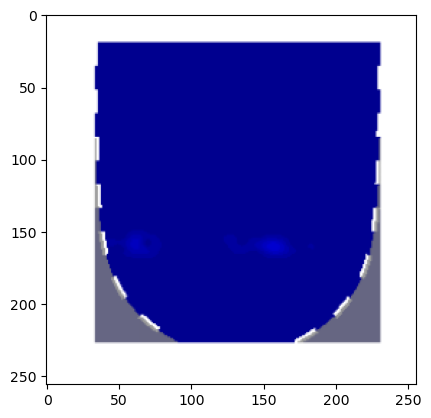

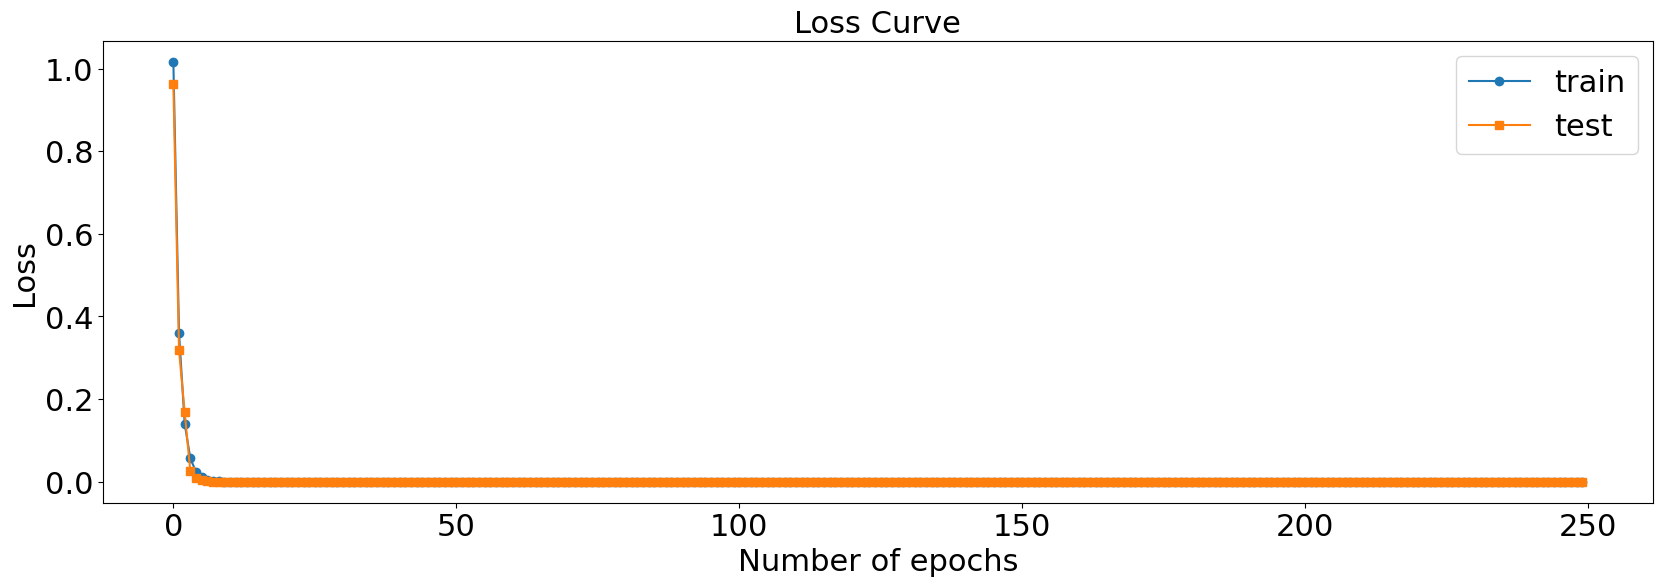

In [21]:
#---Summarize history for loss
plt.figure(figsize=(20,6))
plt.plot(H.history['loss'],'-o')
plt.plot(H.history['val_loss'],'-s')
plt.title('Loss Curve',fontsize=22)
plt.ylabel('Loss',fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Number of epochs',fontsize=22)
plt.legend(['train', 'test'], loc='best',fontsize=22)
#plt.axis([100,250,2.5e-5,1e-4])
#plt.savefig("Loss.png", dpi=150)
plt.show()

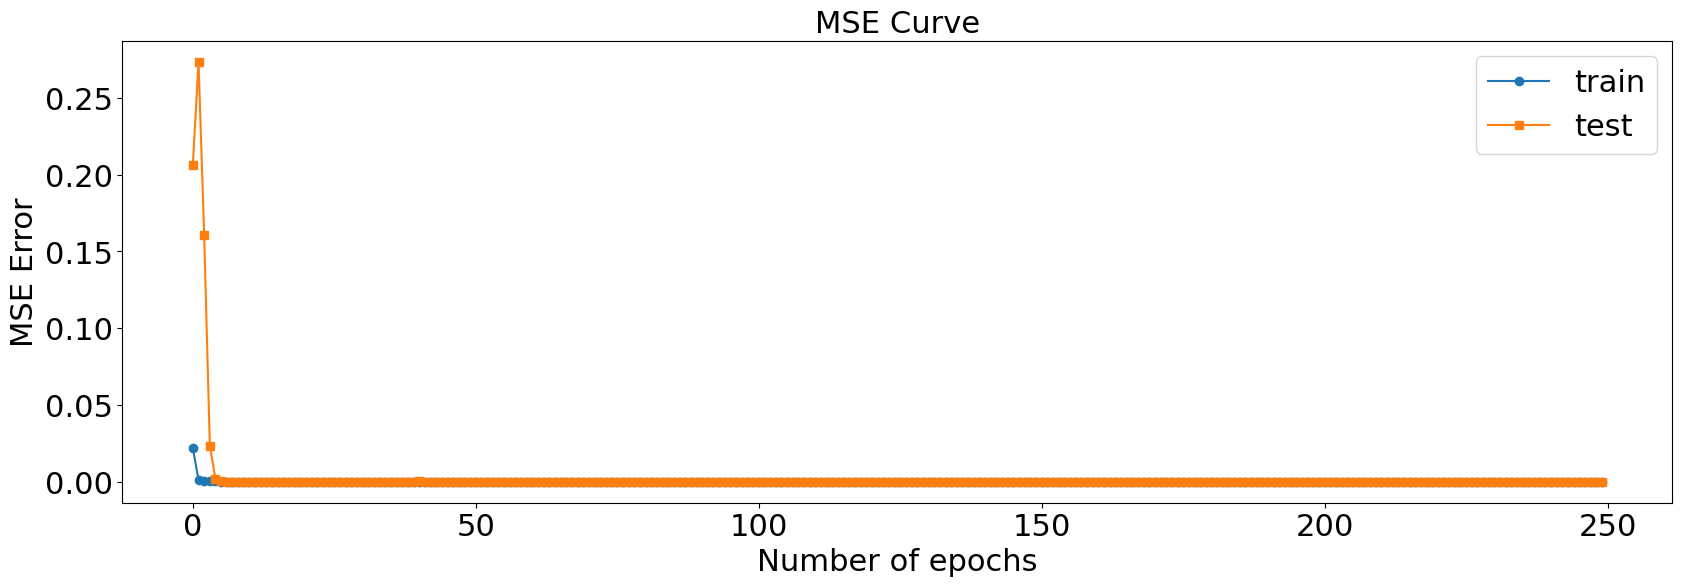

In [22]:
#---Summarize history for MSE reconstruction loss
plt.figure(figsize=(20,6))
plt.plot(H.history['L_mse'],'-o')
plt.plot(H.history['val_L_mse'],'-s')
plt.title('MSE Curve',fontsize=22)
plt.ylabel('MSE Error',fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Number of epochs',fontsize=22)
plt.legend(['train', 'test'], loc='best',fontsize=22)
#plt.axis([50,250,1e-5,1e-4])
#plt.savefig("loss_code2.png", dpi=150)
plt.show()

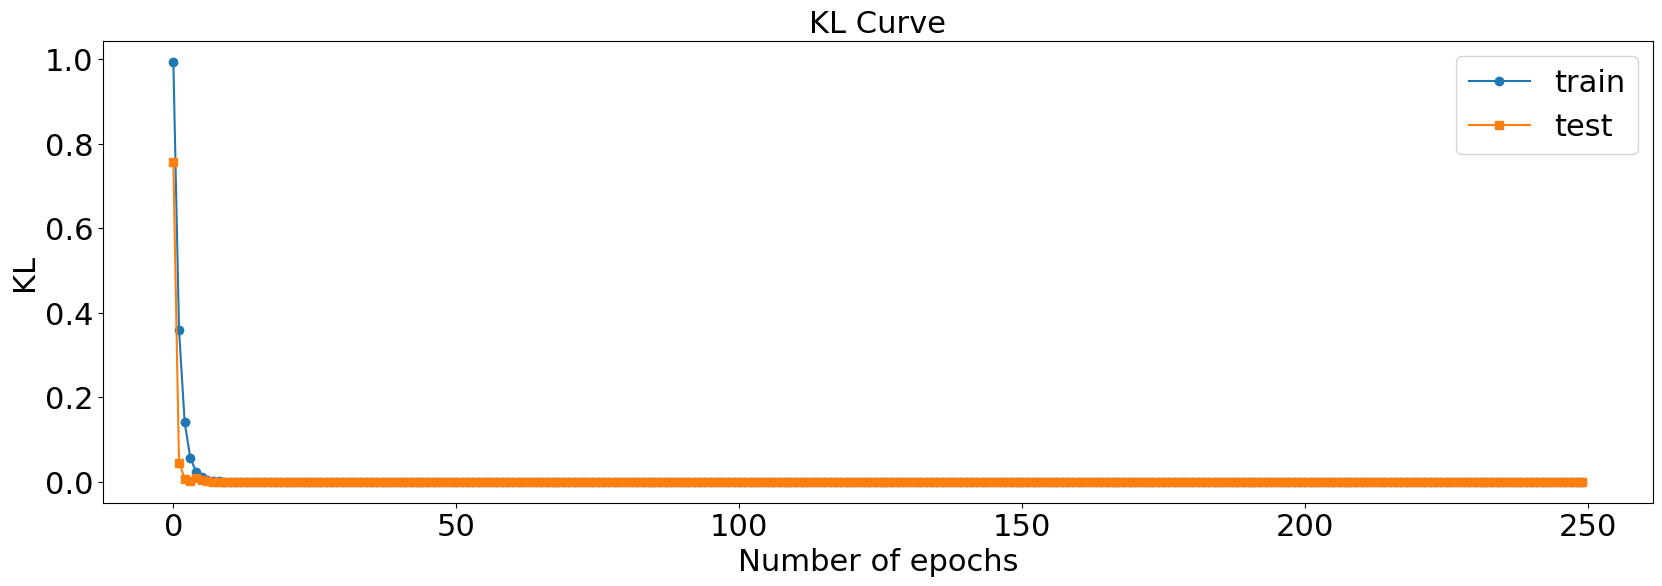

In [23]:
#---Summarize history for KL-Divergence loss
plt.figure(figsize=(20,6))
plt.plot(H.history['L_kl'],'-o')
plt.plot(H.history['val_L_kl'],'-s')
plt.title('KL Curve',fontsize=22)
plt.ylabel('KL',fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Number of epochs',fontsize=22)
plt.legend(['train', 'test'], loc='best',fontsize=22)
#plt.axis([50,250,1e-10,1e-6])
#plt.savefig("loss_code2.png", dpi=150)
plt.show()

### Some functions

In [24]:
# Latent space visualization
def viz_latent_space(encoder, data):
  mu, _, _ = encoder.predict(data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1])
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  #plt.colorbar()
  plt.show()

In [25]:
def viz_decoded(encoder, decoder, traindata):
  num_samples = 15
  figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
  grid_x = np.linspace(-4, 4, num_samples)
  grid_y = np.linspace(-4, 4, num_samples)[::-1]
  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(img_width, img_height, num_channels)
          figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
  plt.figure(figsize=(10, 10))
  start_range = img_width // 2
  end_range = num_samples * img_width + start_range + 1
  pixel_range = np.arange(start_range, end_range, img_width)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
  # So reshape if necessary
  fig_shape = np.shape(figure)
  if fig_shape[2] == 1:
    figure = figure.reshape((fig_shape[0], fig_shape[1]))
  # Show image
  plt.imshow(figure)
  plt.show()

In [26]:
def viz_predictions(InpImg, decoded, mshow):
	# initialize our list of output images
	outputs = None
	# loop over our number of output samples
	for i in mshow:
		# grab the original image and reconstructed image
		original = (InpImg[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")

		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])

		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output

		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])

	# return the output images
	return outputs

In [27]:
def calculate_errors(meanval, sigmaval, samples, pred_samples):
    errors = []
    n = 0
    # get the training loss
    for (image, recon) in zip(samples, pred_samples):
        n = n + 1
        mse = np.mean((image - recon)**2)
        #bce = - (samples * np.log(pred_samples) + (1 - samples) * np.log(1-pred_samples))
        #bce = np.sum(bce, axis = -1)
        # mu[n-1,:] & sigma[n-1,:] will fetch mu & sigma corresponding to each training example
        kl = -0.5 * (1 + sigmaval[n-1,:] - meanval[n-1,:]**2 - np.exp(sigmaval[n-1,:]))
        kl_loss = np.mean(np.sum(kl))
        total_loss = mse + kl_loss
        errors.append(total_loss)
    return errors

### Visualization of reconstructed images & Latent space

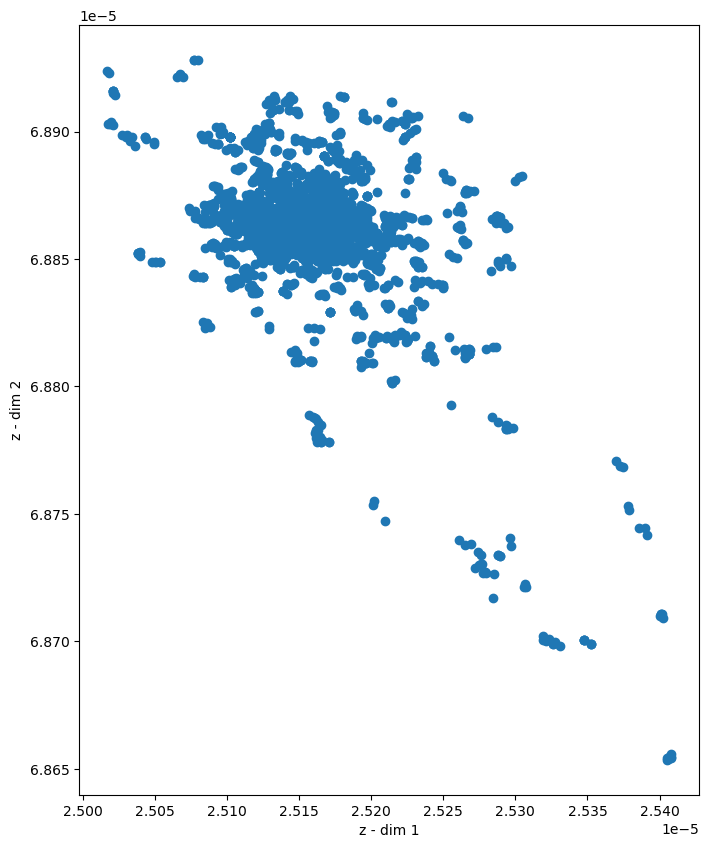

In [28]:
# Visualize the latent space
viz_latent_space(encoder, trainX)

In [29]:
# visualize the predictions with train dataset
import random
trainXpred = vae.predict(trainX)
print(trainXpred.shape)
npred = trainXpred.shape[0]
vect = np.arange(1,npred,1)
mshow = np.random.choice(vect, 1)

print(mshow)
vis = viz_predictions(trainX, trainXpred, mshow)
plt.figure(figsize=(20,8))
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('CAE: (Left) Input Image ; (Right) Reconstructed Input',fontsize=25)
plt.imshow(vis)
#plt.savefig("predsample.png", dpi=150)

(4250, 256, 256, 3)
[2930]


### Threshold for Anomaly detection

In [30]:
mu, sigma, z = encoder.predict(trainX)
errors = calculate_errors(mu, sigma, trainX, trainXpred)

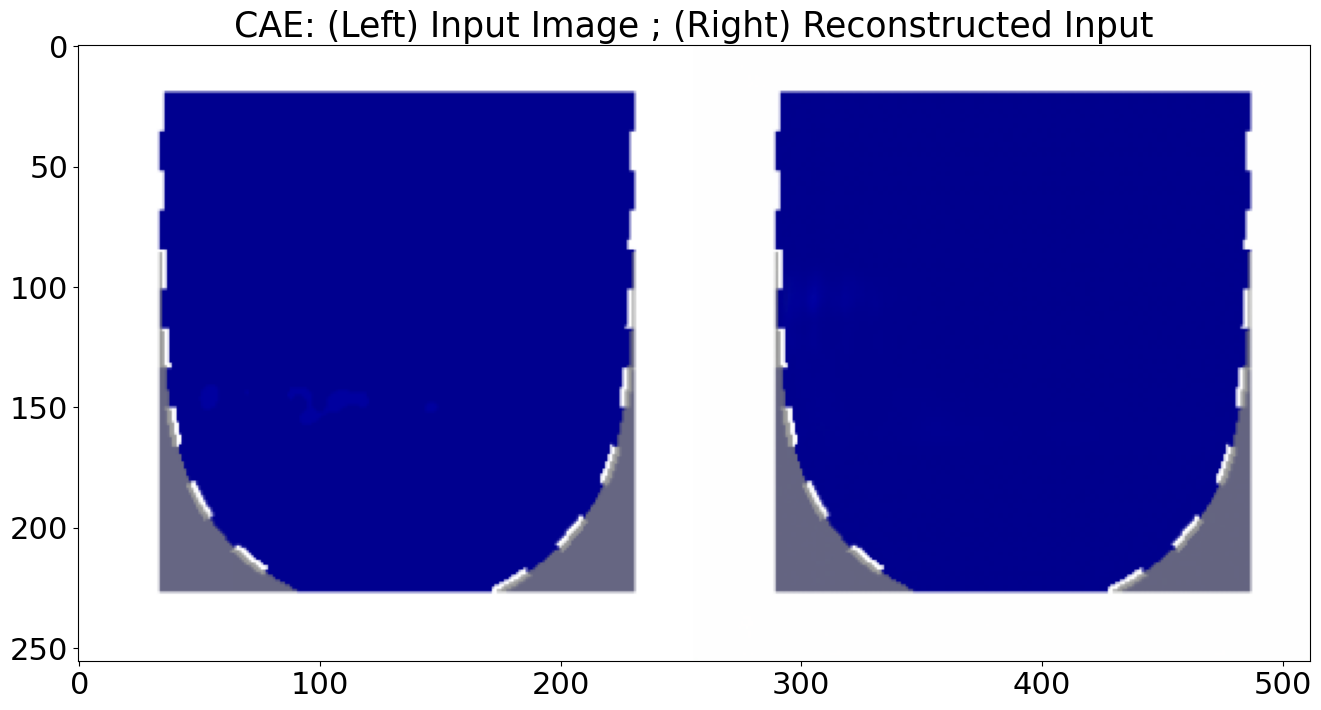

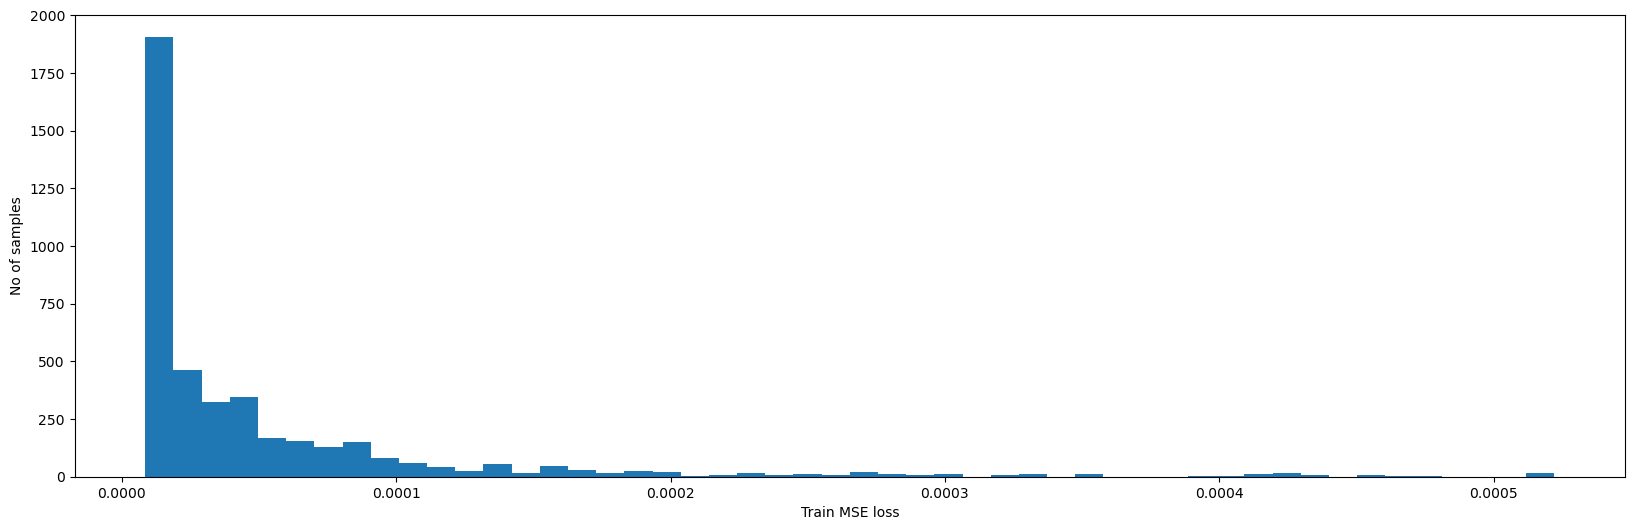

In [31]:
plt.figure(figsize=(20,6))
plt.hist(errors, bins=50)
plt.xlabel("Train MSE loss")
plt.ylabel("No of samples")
plt.show()

In [32]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
threshold1 = np.quantile(errors, 0.99)
print("[INFO] mse threshold 1: {}".format(threshold1))

[INFO] mse threshold 1: 0.00042440321791218597


In [33]:
# Get reconstruction loss threshold based on maximum value
threshold2 = np.max(errors)
print("Reconstruction error threshold 2: ", threshold2)

Reconstruction error threshold 2:  0.0005219939


### Anomaly Detection: Prediction on validation "healthy" samples

In [34]:
# this test set has only baseline signals
testXpred = vae.predict(testX)
print(testXpred.shape)

mu_v, sigma_v, z_v = encoder.predict(testX)
errors_v = calculate_errors(mu_v, sigma_v, testX, testXpred)

(750, 256, 256, 3)


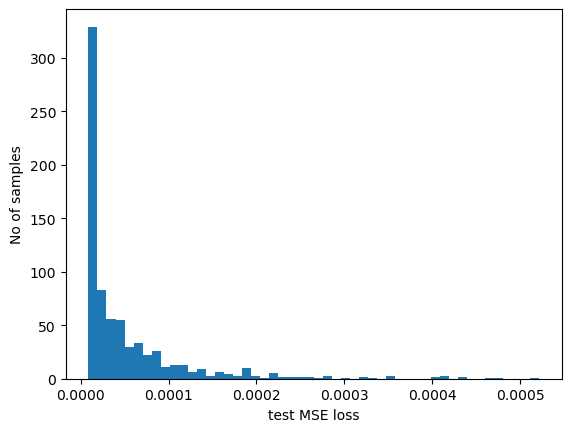

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)


In [35]:
plt.hist(errors_v, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = errors_v > threshold2
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

### Anomaly Detection: Prediction on validation "unhealthy" samples

In [36]:
# this test set has damaged signals
# n1 to n2 defines the range of the images used
n1 = random.randint(0, 1559-50)
n2 = n1 + 50
#testX_d = imagesD[n1:n2]
testX_d = imD
print(testX_d.shape)

(5000, 256, 256, 3)


In [37]:
# this test set has only damaged signals
testXpred_d = vae.predict(testX_d)
print("Test set with all damaged samples", testXpred_d.shape)

mu_d, sigma_d, z_d = encoder.predict(testX_d)
errors_d = calculate_errors(mu_d, sigma_d, testX_d, testXpred_d)

Test set with all damaged samples (5000, 256, 256, 3)


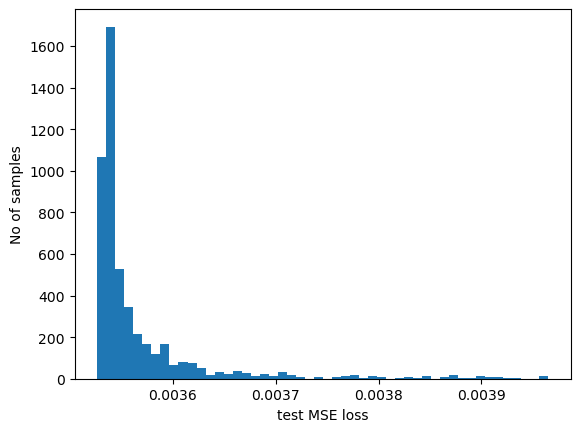

Number of anomaly samples:  5000
Indices of anomaly samples:  (array([   0,    1,    2, ..., 4997, 4998, 4999], dtype=int64),)


In [38]:
plt.hist(errors_d, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies_d = errors_d > threshold2
print("Number of anomaly samples: ", np.sum(anomalies_d))
print("Indices of anomaly samples: ", np.where(anomalies_d))

In [39]:
errors_all = np.concatenate((np.array(errors_v), np.array(errors_d)), axis=0)
print(errors_all.shape)

(5750,)


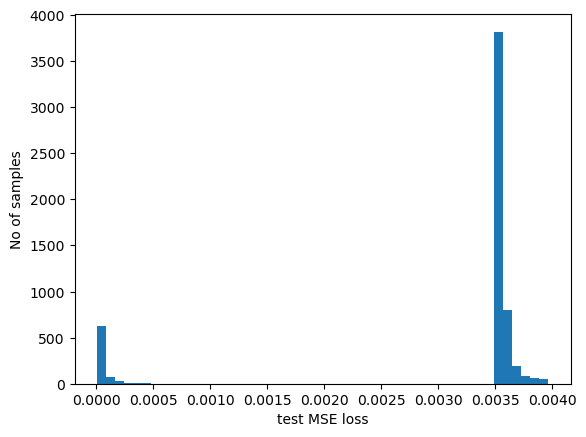

In [40]:
plt.hist(errors_all, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
#anomalies_d = errors_d > threshold1
#print("Number of anomaly samples: ", np.sum(anomalies_d))
#print("Indices of anomaly samples: ", np.where(anomalies_d))

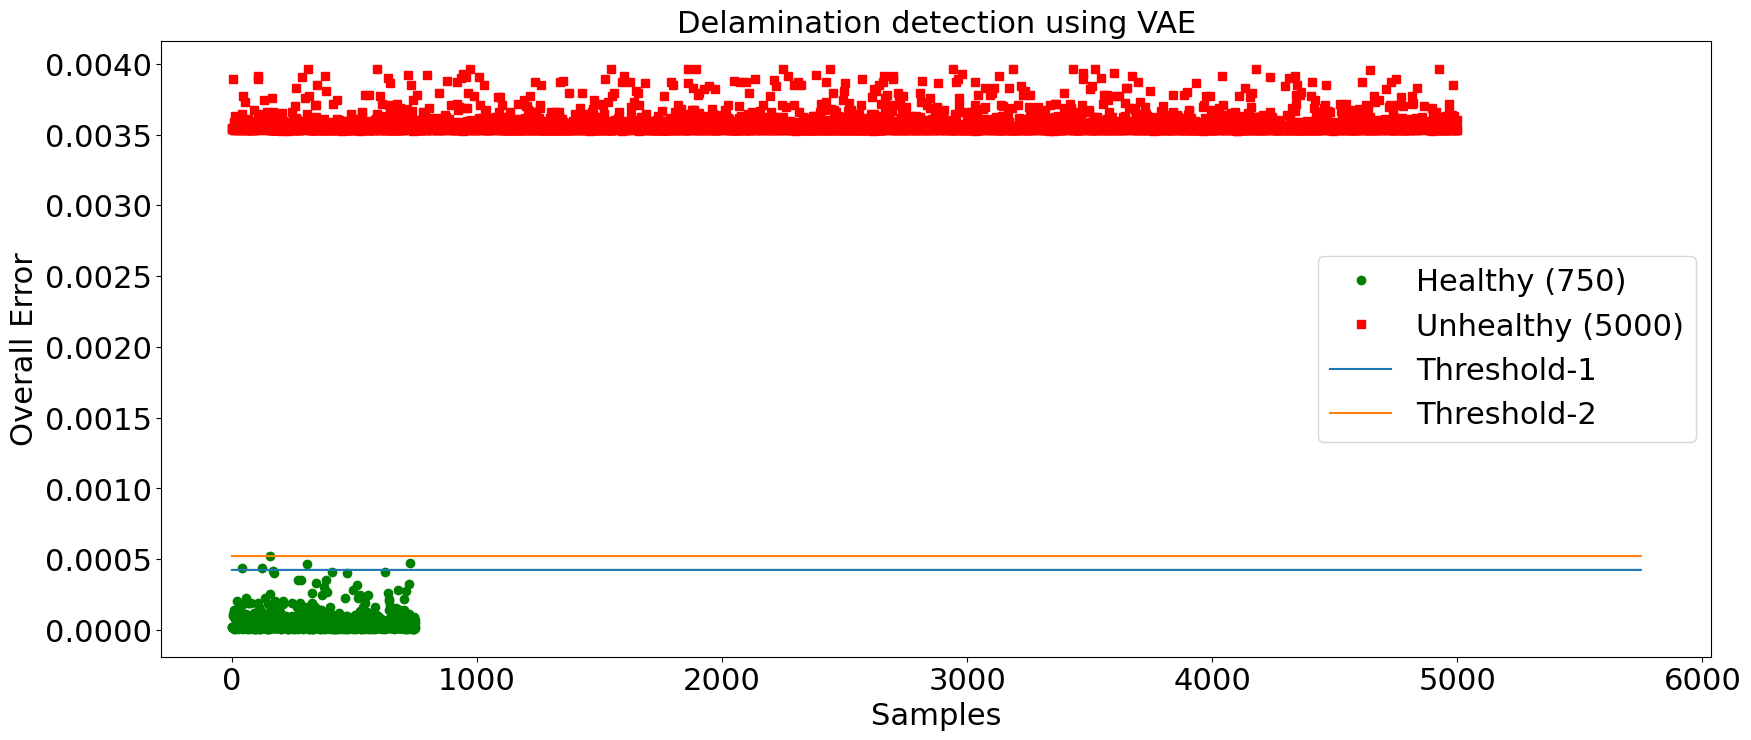

In [49]:
plt.figure(figsize=(20,8))
plt.plot(errors_v,'og')
plt.plot(errors_d,'sr')
plt.plot(threshold1 * np.ones(errors_all.shape[0]), '-')
plt.plot(threshold2 * np.ones(errors_all.shape[0]), '-')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Delamination detection using VAE",fontsize=22)
plt.xlabel("Samples",fontsize=22)
plt.ylabel("Overall Error",fontsize=22)
plt.legend(['Healthy (750)', 'Unhealthy (5000)','Threshold-1','Threshold-2'], loc='best',fontsize=22)
plt.savefig("VAEthresholds.png", dpi=750)
plt.show()

### Plot the overall latent space

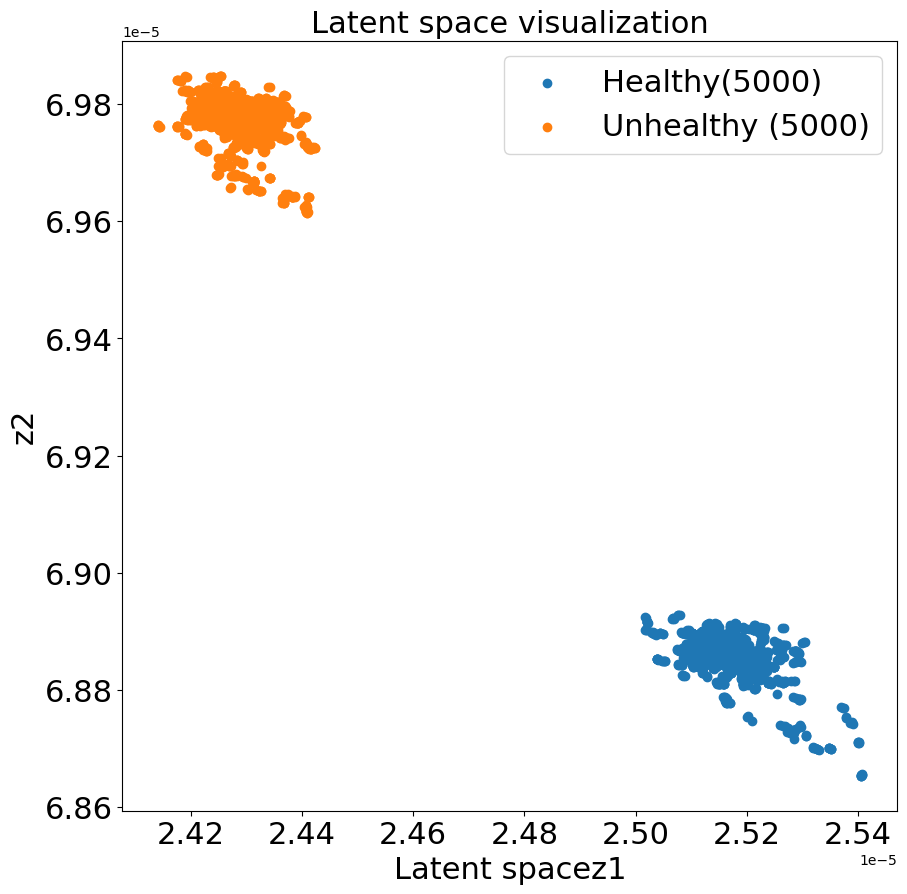

In [57]:
# Visualize the latent space of both healthy and unhealthy
mu1, _, _ = encoder.predict(trainX)
mu2, _, _ = encoder.predict(testX)
mu3, _, _ = encoder.predict(testX_d)

plt.figure(figsize=(10, 10))
plt.scatter(mu1[:, 0], mu1[:, 1])
#plt.scatter(mu2[:, 0], mu2[:, 1])
plt.scatter(mu3[:, 0], mu3[:, 1])
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title("Latent space visualization",fontsize=22)
plt.xlabel('z1',fontsize=22)
plt.ylabel('z2',fontsize=22)
#plt.colorbar()
plt.legend(['Healthy(5000)', 'Unhealthy (5000)'], loc='best',fontsize=22)
plt.savefig("VAElatent.png", dpi=750)
plt.show()